**Importing Required Libraries**

In [7]:
from google.colab import drive

# Connect to Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from keras.models import Model
from tensorflow.keras.models import load_model
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image
from tensorflow.keras.callbacks import EarlyStopping
from google.colab import drive
import os
import shutil
from sklearn.model_selection import train_test_split


In [9]:


# Chemin vers le répertoire contenant votre ensemble de données sur Google Drive
dataset_dir = '/content/drive/MyDrive/flowers'

# Créer les répertoires pour l'entraînement, la validation et le test
base_dir = '/content/drive/MyDrive/flower_dataset_splitted'
os.makedirs(base_dir, exist_ok=True)

train_dir = os.path.join(base_dir, 'train')
os.makedirs(train_dir, exist_ok=True)

val_dir = os.path.join(base_dir, 'val')
os.makedirs(val_dir, exist_ok=True)

test_dir = os.path.join(base_dir, 'test')
os.makedirs(test_dir, exist_ok=True)

# Copier les images dans les répertoires d'entraînement, de validation et de test
for class_folder in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_folder)
    images = os.listdir(class_path)

    # Vérifiez si la taille de l'ensemble d'entraînement est suffisamment grande
    if len(images) < 2:
        continue

    train_images, test_val_images = train_test_split(images, test_size=0.2, random_state=42)

    # Vérifiez si la taille de l'ensemble de validation et de test est suffisamment grande
    if len(test_val_images) < 2:
        continue

    val_images, test_images = train_test_split(test_val_images, test_size=0.5, random_state=42)

    # Créez des sous-répertoires par classe dans les ensembles d'entraînement, de validation et de test
    train_class_dir = os.path.join(train_dir, class_folder)
    os.makedirs(train_class_dir, exist_ok=True)

    val_class_dir = os.path.join(val_dir, class_folder)
    os.makedirs(val_class_dir, exist_ok=True)

    test_class_dir = os.path.join(test_dir, class_folder)
    os.makedirs(test_class_dir, exist_ok=True)

    for img in train_images:
        src_path = os.path.join(class_path, img)
        dest_path = os.path.join(train_class_dir, img)
        shutil.copy(src_path, dest_path)

    for img in val_images:
        src_path = os.path.join(class_path, img)
        dest_path = os.path.join(val_class_dir, img)
        shutil.copy(src_path, dest_path)

    for img in test_images:
        src_path = os.path.join(class_path, img)
        dest_path = os.path.join(test_class_dir, img)
        shutil.copy(src_path, dest_path)

# Vérifiez le nombre d'images dans chaque sous-répertoire des ensembles d'entraînement, de validation et de test
print(f"Train Set: {sum(len(os.listdir(os.path.join(train_dir, class_folder))) for class_folder in os.listdir(train_dir))} images")
print(f"Validation Set: {sum(len(os.listdir(os.path.join(val_dir, class_folder))) for class_folder in os.listdir(val_dir))} images")
print(f"Test Set: {sum(len(os.listdir(os.path.join(test_dir, class_folder))) for class_folder in os.listdir(test_dir))} images")



KeyboardInterrupt: 

**Data Preparation**

In [10]:
input_shape = (224, 224, 3)
num_classes = 5
batch_size = 32

# Define preprocess_input function
def preprocess_input(image):
    """
    Preprocesses an image for use with a pre-trained model.
    This function assumes that the input image is in the range [0, 255].
    """
    # Convert image to float32 and normalize it to the range [0, 1]
    image = image.astype('float32') / 255.0
    # Subtract mean pixel values (assuming RGB order) to center the data
    image -= np.array([0.485, 0.456, 0.406])
    # Divide by std deviation of pixel values (assuming RGB order) to scale the data
    image /= np.array([0.229, 0.224, 0.225])
    return image

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

train_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/flower_dataset_splitted/train',
    target_size = input_shape[:2],
    batch_size = batch_size,
    class_mode = 'categorical'
)

validation_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/flower_dataset_splitted/val',
    target_size = input_shape[:2],
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False
)

test_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/flower_dataset_splitted/test',
    target_size = input_shape[:2],
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False
)

Found 3452 images belonging to 5 classes.
Found 430 images belonging to 5 classes.
Found 435 images belonging to 5 classes.


In [11]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import models

input_shape = (224, 224, 3)
num_classes = 5

# Define the CNN model
model = models.Sequential([
    # Convolutional layers
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    # Flatten the output of the convolutional layers
    Flatten(),
    # Dense (fully connected) layers with dropout
    Dense(1024, activation='relu'),
    Dropout(0.5),  # Adding dropout layer
    Dense(512, activation='relu'),
    Dropout(0.5),  # Adding dropout layer
    Dense(256, activation='relu'),
    # Dense (fully connected) layers with dropout
    Dense(64, activation='relu'),
    Dropout(0.5),  # Adding dropout layer
    Dense(num_classes, activation='softmax')  # Output layer with softmax activation for classification
])

# Print model summary
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 26, 26, 64)       

In [12]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [13]:
# Train the model
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="loss", mode ="min", patience = 5, restore_best_weights = True)
history = model.fit(
    train_generator,
    epochs = 10,
    validation_data = validation_generator,
    batch_size = batch_size,
    callbacks =[earlystopping],
    verbose = 1
)

Epoch 1/10
108/108 [==============================] - 799s 7s/step - loss: 1.7305 - accuracy: 0.2297 - val_loss: 1.5464 - val_accuracy: 0.2488
Epoch 2/10
108/108 [==============================] - 71s 660ms/step - loss: 1.5961 - accuracy: 0.2402 - val_loss: 1.5986 - val_accuracy: 0.2442
Epoch 3/10
108/108 [==============================] - 68s 626ms/step - loss: 1.6001 - accuracy: 0.2370 - val_loss: 1.5987 - val_accuracy: 0.2442
Epoch 4/10
108/108 [==============================] - 70s 645ms/step - loss: 1.5993 - accuracy: 0.2457 - val_loss: 1.5989 - val_accuracy: 0.2279
Epoch 5/10
108/108 [==============================] - 67s 622ms/step - loss: 1.6004 - accuracy: 0.2390 - val_loss: 1.5983 - val_accuracy: 0.2442
Epoch 6/10
108/108 [==============================] - 71s 657ms/step - loss: 1.6005 - accuracy: 0.2520 - val_loss: 1.5984 - val_accuracy: 0.2442
Epoch 7/10
108/108 [==============================] - 68s 634ms/step - loss: 1.5995 - accuracy: 0.2445 - val_loss: 1.5994 - val_accu

In [14]:
# save the model
model.save('model/CNN_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [15]:

# Evaluate the model on test data
loss, accuracy = model.evaluate(test_generator)

# Print the loss and accuracy
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

14/14 [==============================] - 98s 8s/step - loss: 1.5989 - accuracy: 0.2437
Test Loss: 1.5988556146621704
Test Accuracy: 0.24367816746234894


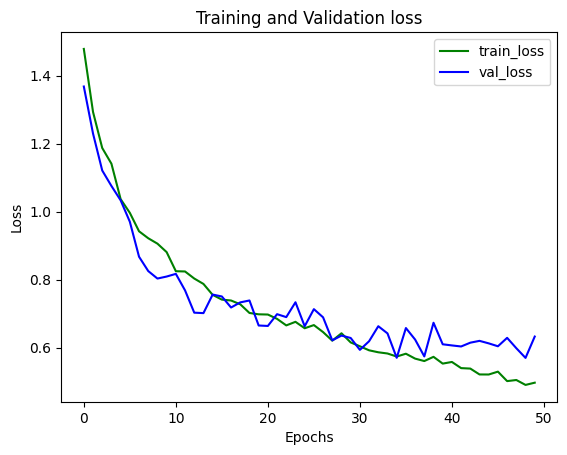

In [ ]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

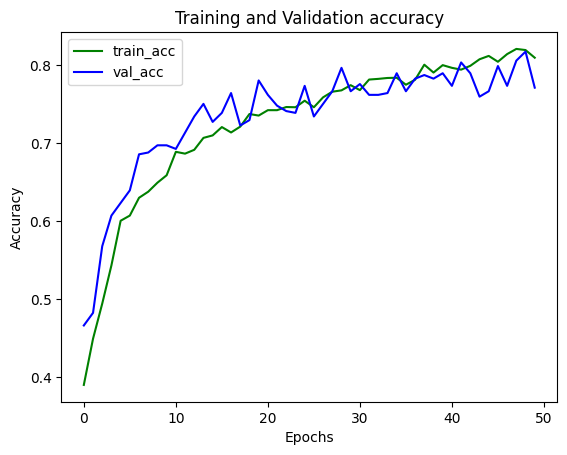

In [ ]:
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Evaluation
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

model = load_model('model/CNN_model.h5')

# Get the true labels for the test set
y_true = test_generator.classes
# Get the class indices
class_indices = test_generator.class_indices

# Convert the class indices to class names
class_names = list(class_indices.keys())

# Use the model to predict the labels for the test set
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)

# y_true and y_pred are true and predicted labels
print(classification_report(y_true, y_pred, target_names=class_names))

# Compute evaluation metrics
print("Confusion matrix : \n",confusion_matrix(y_true, y_pred))

14/14 [==============================] - 13s 933ms/step
              precision    recall  f1-score   support

       daisy       0.87      0.71      0.79        77
   dandelion       0.80      0.87      0.83       106
        rose       0.75      0.58      0.66        79
   sunflower       0.77      0.89      0.82        74
       tulip       0.75      0.83      0.78        99

    accuracy                           0.78       435
   macro avg       0.79      0.78      0.78       435
weighted avg       0.79      0.78      0.78       435

Confusion matrix : 
 [[55 12  4  4  2]
 [ 1 92  4  9  0]
 [ 3  2 46  4 24]
 [ 2  4  0 66  2]
 [ 2  5  7  3 82]]


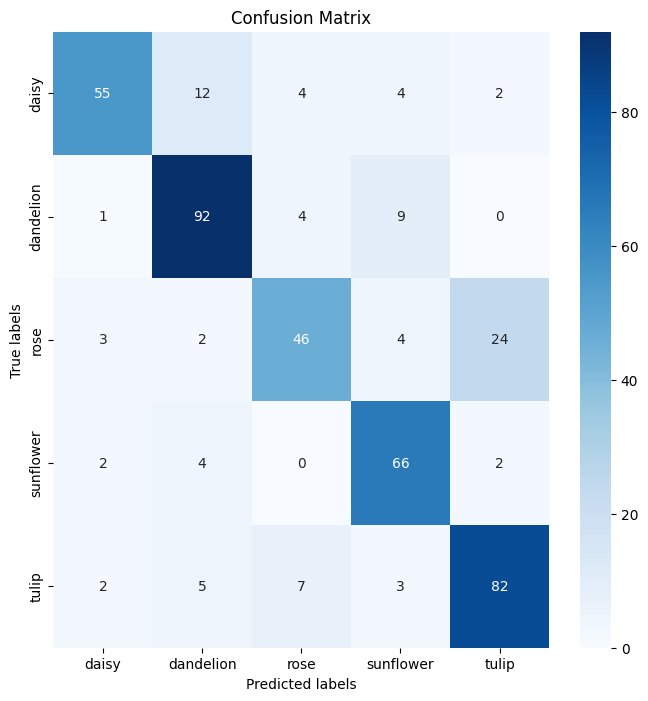

In [ ]:
# Compute confusion matrix
confusion_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()